Hunter S. DiCicco

with Dr. Dongwon Lee, Ph.D.

# Multinomial SVC for Categories of News

## Diagnostics to Assess Model Performance

### Setup and Imports

In [54]:
import pickle
import glob
import sys
import os

from itertools import combinations
from subprocess import Popen

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

try:
    import feature_extraction
except ModuleNotFoundError:
    os.chdir("../")
    import feature_extraction

def main():
    """
    Instead of an import, we wrap the execution of both of these vital modules within `exec`.
    This ensures that changes are enacted on every chunk evaluation.
    """
    exec(open("classifier.py").read(), globals())
    exec(open("validator.py").read(), globals())

try:
    main()
except FileNotFoundError:
    os.chdir("../")
    main()

Retreiving data...
Retreiving data...
Retreiving data...
Retreiving data...
[LibSVM]recall: [0.7  0.93 0.03 0.3  0.89]
precision [0.83 0.87 0.5  0.24 0.5 ]
f1: [0.76 0.9  0.06 0.27 0.64]
{1: 68, 2: 16, 3: 217, 5: 156, 7: 24}
This model got 57.05% correct || 639 out of 1120
False negatives for real data (1)
{5: 55, 2: 13}
False negatives for fake data (2)
{5: 8, 7: 8}
False negatives for opinion data (3)
{5: 147, 2: 5, 1: 12, 7: 53}
False negatives for polarized data (5)
{7: 139, 3: 4, 2: 13}
False negatives for satire data (7)
{1: 21, 3: 3}


In [2]:
def load_latest_model(kernel=''):
    """
    Loads and returns the latest model from the `models` directory with the user-specified kernel.
    """
    # obtain a glob of the files in the `models` directory
    list_of_files = glob.glob(f"../models/*{kernel}*.pickle")

    # obtain the model which was created most recently
    # using the sorting key of creation time
    latest_model = max(list_of_files, key=os.path.getctime)

    # open the most recent model and load it into the namespace
    # WARNING: only load pickle files that you trust! do not allow arbitrary execution
    with open(latest_model, mode="rb") as filein:
        model = pickle.load(filein)
    return model

NOTES: *Some of the insights on linear feature importance used below obtained from [here](https://stackoverflow.com/a/22831491).*

*`plot_coefficients` method initially obtained from [here](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d)*

In the next chunk we will use our models' support vectors to perform feature selection.

Each feature used in the SVM's training has its associated weight vector(s) which encode that feature's influence on assigning class label(s) during inference.

In the linear case interpreting these weight vectors to select features is simple.

First we will load the most recent *linear* model and obtain its support vectors.
Our linear support matrix will be of shape `(problems, features)=(10, 18)` because there are 18 features in use for training, and `(n_classes * [(n_classes - 1) / 2])=10` one-versus-rest separation problems per feature where `n_classes=5`. In order to consider overall *feature* weight, we transpose this matrix.

We will only consider the magnitude of each feature-weight vectors in order to derive feature importance. If we wish to get more granular we could inspect the differences in variance between specific classes under specific features (or elements of the feature-weight vectors).

We will be calculating what are called the "Dual Coefficients" for this model.
They will be contained in a vector...

[(1, 2), (1, 3), (1, 5), (1, 7), (2, 3), (2, 5), (2, 7), (3, 5), (3, 7), (5, 7)] 10


[Text(0, 0.5, 'Variance Magnitude'), Text(0.5, 0, 'Feature')]

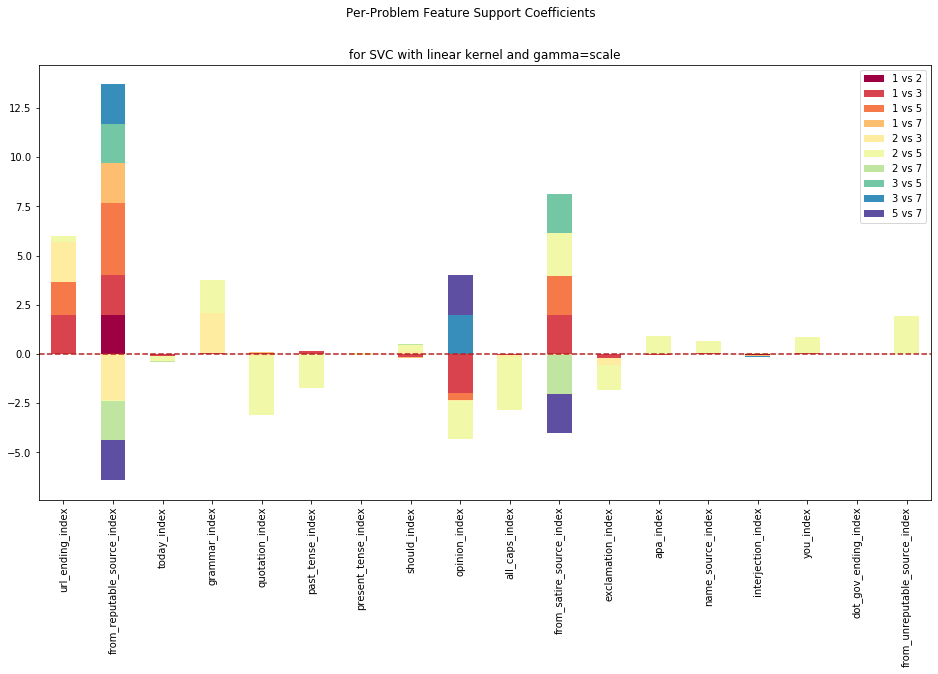

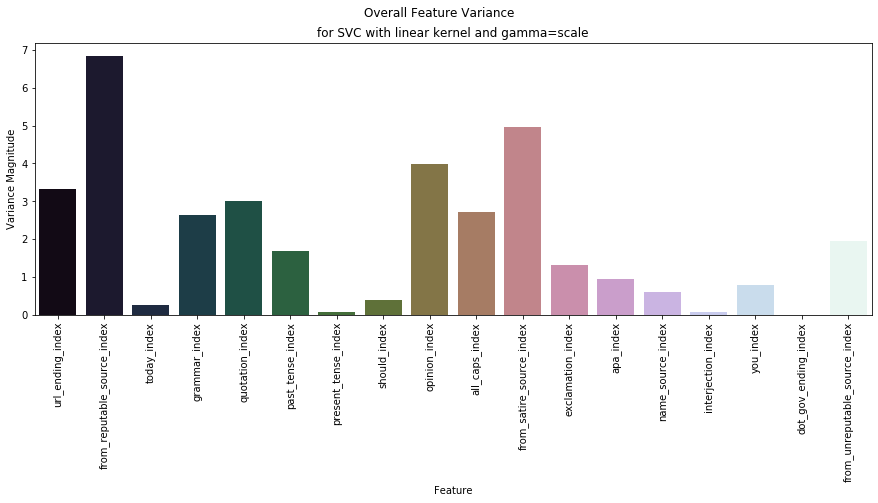

In [60]:
# list of features in use
xlab = ["url_ending_index", "from_reputable_source_index",
        "today_index", "grammar_index", "quotation_index",
        "past_tense_index", "present_tense_index", "should_index",
        "opinion_index", "all_caps_index", "from_satire_source_index",
        "exclamation_index", "apa_index", "name_source_index",
        "interjection_index", "you_index", "dot_gov_ending_index",
        "from_unreputable_source_index"]

# load latest linear model
model = load_latest_model(kernel='linear')

# we are only writing procedures for linear and rbf
# linear has easy-to-interpret feature-weight calculations
# and rbf has a well-established process to make them simpler to interpret
if not model.kernel in ("linear", "rbf"):
    raise AttributeError('Initial model kernel is not linear. Only linear kernels have dual coefficients for class support weights.')

# first we look at the linear model


def plot_coefficients(classifier, feature_names, top_features=20):
    """
    Method Docstring Placeholder
    """
    classes = classifier.classes_
    n_classes = len(classes)
    
    classes = list(combinations(classes, 2))
    print(classes, len(classes))

    coef = pd.DataFrame(classifier.coef_, columns=feature_names)
    
    ax = coef.T.plot(kind="bar",
                stacked=True,
                figsize=(16,8),
                colormap="Spectral",
                title=f"for SVC with {classifier.kernel} kernel and gamma={classifier.gamma!s}")

    legend = ax.get_legend()

    for i, label in enumerate(legend.get_texts()):
        label.set_text(f"{classes[i][0]} vs {classes[i][1]}")

    plt.axhline(linestyle='dashed', color='firebrick')
    plt.suptitle("Per-Problem Feature Support Coefficients")

plot_coefficients(model, xlab, top_features=18)

# obtain the number of classes
# as well as weights for supports of each class
(n_classes, coefs) = *(len(model.classes_), model.coef_.transpose()),

# sort of a hack:
# take the vector norm ([x dot x]^(1/2)) of each 
coefs = np.apply_along_axis(lambda x: np.sqrt(x.dot(x)), 1, coefs)

### plotting
plt.figure(figsize=(15,5))
ax = sns.barplot(xlab, coefs, palette=sns.color_palette("cubehelix", len(xlab)))
ax.set_title(f"for SVC with {model.kernel} kernel and gamma={model.gamma!s}")
plt.suptitle("Overall Feature Variance")
ax.set_xticklabels(xlab, rotation=90)
ax.set(xlabel='Feature', ylabel='Variance Magnitude')
###

# load latest rbf model
#model = load_latest_model(kernel='rbf')

#support_indices = np.cumsum(model.n_support_)

# each vector in the list below represents the support vectors for 
#coefs = model.dual_coef_
